# Tutorial - Iris data 

In this tutorial, we demonstrate the basic usage of **Bayesian Principal Component Analysis (BPCA)** on the well-known **Iris dataset**. To study the behavior of BPCA under incomplete observations, we artificially introduce missing values **completely at random (MCAR)** and assess how well the resulting low-dimensional representations agree with a PCA embedding obtained from the complete data.

Rather than benchmarking competing methods under identical conditions, this tutorial uses PCA on complete data as a *reference solution* to evaluate how robustly BPCA recovers the underlying structure as the fraction of missing entries increases.

## Setup

We begin by importing the required libraries and defining helper functions for simulating missing data and evaluating agreement between PCA embeddings.
We rely on standard scientific Python libraries together with an implementation of Bayesian PCA.

### Imports

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from bpca import BPCA
import matplotlib as mpl

### Functions
We define a small set of helper functions to (i) introduce missing values into the dataset under a controlled missing-completely-at-random (MCAR) mechanism and (ii) quantify the agreement between low-dimensional embeddings obtained from BPCA and PCA.

In [40]:
def introduce_missing_values(X: np.ndarray, p_missing: float) -> np.ndarray:
    """Introduce missing values completely at random (entry-wise)

    Parameters
    ----------
    X
        Complete data (n_obs, n_var)
    p_missing
        Probability for a value to be missing

    Returns
    -------
    numpy.ndarrary
        Copy of array with shape (n_obs, n_var) with missing values as np.nan. Note that while the probability of a missing value
        in the generative process is `p_missing`, but the fraction of actually missing values might differ from this
    """
    X = X.astype(float).copy()
    mask = np.random.choice([True, False], size=X.shape, p=[p_missing, 1 - p_missing], replace=True)
    X[mask] = np.nan

    return X

In [41]:
def plot_pca(
    usage: np.ndarray,
    c: np.ndarray,
    explained_variance: np.ndarray | None = None,
    ax: mpl.axes.Axes | None = None,
    title: str | None = None,
) -> mpl.axes.Axes:
    """PCA plot"""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.scatter(usage[:, 0], usage[:, 1], marker="o", linestyle="", c=c)

    if title is not None:
        ax.set_title(title, loc="left", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["top", "right"]].set_visible(False)

    ax.set_xlabel(f"PC1 - {explained_variance[0] * 100:.0f}%", fontsize=16)
    ax.set_ylabel(f"PC2 - {explained_variance[1] * 100:.0f}%", fontsize=16)

    return ax

In [42]:
def mean_correlation(query: np.ndarray, reference: np.ndarray) -> float:
    """Compute median correlation between a query and its reference"""
    pairwise_correlation = cdist(query, reference, metric=lambda x, y: (pearsonr(x, y).statistic) ** 2)
    pairwise_correlation[np.isnan(pairwise_correlation)] = 0
    query_idx, reference_idx = linear_sum_assignment(pairwise_correlation, maximize=True)

    return float(np.mean(pairwise_correlation[query_idx, reference_idx]))

## Run

We use the Iris dataset, which consists of four morphological features measured for 150 flower samples from three *Iris* species. The dataset is low-dimensional and well structured, making it suitable for illustrating the effects of missing data on PCA-based embeddings.

In [43]:
iris_dataset = load_iris()
X = iris_dataset["data"]
species = iris_dataset["target"]

We apply **BPCA** to versions of the dataset with increasing fractions of missing entries, introduced independently for each observation and feature under an MCAR assumption. The 

In [44]:
probabilities = [0, 0.1, 0.25, 0.5, 0.75]

The `BPCA` class follows the same high-level API as `sklearn.decomposition.PCA`. For each missingness level, we:

1. Fit BPCA to the incomplete dataset  
2. Compare the resulting latent dimensions to a PCA embedding obtained from the complete data  
3. Visualize the low-dimensional representations

/var/folders/py/838_q5nd6594y27wbrpkhl3h0000gn/T/ipykernel_91799/365368244.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pairwise_correlation = cdist(query, reference, metric=lambda x, y: (pearsonr(x, y).statistic)**2)


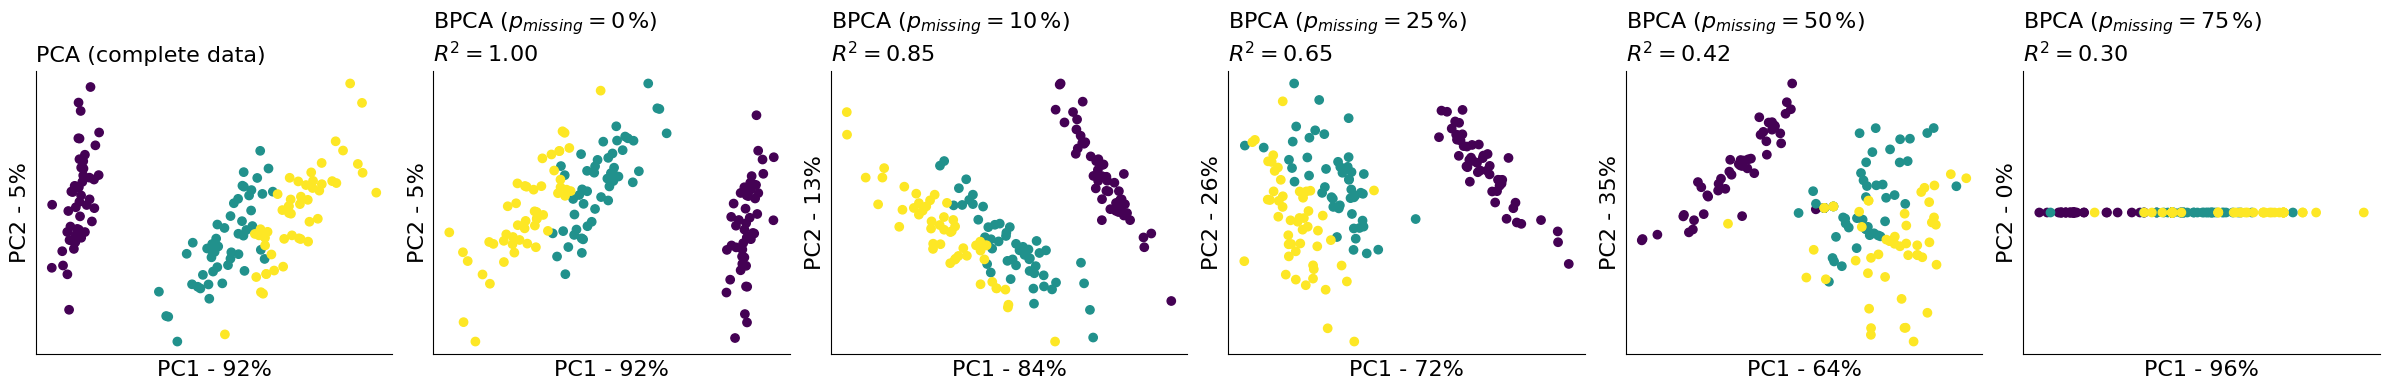

In [46]:
fig, axs = plt.subplots(1, 1 + len(probabilities), figsize=(4 * (1 + len(probabilities)), 4))

# Run default PCA with sklearn
pca = PCA(n_components=2)
pca_usage = pca.fit_transform(X)
explained_variance_ratio = pca.explained_variance_ratio_
plot_pca(
    usage=pca_usage, c=species, explained_variance=explained_variance_ratio, ax=axs[0], title="PCA (complete data)"
)

for p, ax in zip(probabilities, axs[1:].ravel(), strict=True):
    X_missing = introduce_missing_values(X, p_missing=p)

    # Fit Bayesian PCA on missing data
    bpca = BPCA(n_components=2)
    usage = bpca.fit_transform(X_missing)
    explained_variance = bpca.explained_variance_ratio_
    dimension_order = np.argsort(explained_variance)[::-1]

    r2 = mean_correlation(query=usage.T, reference=pca_usage.T)

    title = f"BPCA ($p_{{missing}} = {p * 100:.0f}\\,\\%$)\n$R^2={r2:.2f}$"

    # Plot
    plot_pca(
        usage=usage[:, dimension_order],
        c=species,
        explained_variance=explained_variance[dimension_order],
        ax=ax,
        title=title,
    )

plt.tight_layout()
plt.show()

For low missingness values, BPCA closely recovers the PCA results obtained from the complete dataset. As the fraction of missing entries increases, performance degrades with respect to the correlation with the reference embedding. Nevertheless, even at high missingness levels, BPCA still recovers the overall structure of the data (especially separation by orchid species).

We emphasize that this experiment considers missingness completely at random and uses PCA on complete data as a reference; behavior may differ under more structured or biologically realistic missingness patterns.
